In [12]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import binom
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
from numpy.random import rand
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [14]:
pd.set_option('display.float_format', lambda x:'%3f' %x)

In [15]:
%matplotlib inline

• PROJECT OBJECTIVE: To understand K-means Clustering by applying on the Car Dataset to segment the cars into various categories

1. Data Understanding & Exploration:

1.A. Read ‘Car name.csv’ as a DataFrame and assign it to a variable

In [16]:
%cd /content/gdrive/My Drive/Colab Notebooks/
df_car_name = pd.read_csv("Part1_Car_name.csv")
df_car_name['ID'] = df_car_name.index
df_car_name.head()


/content/gdrive/My Drive/Colab Notebooks


,car_name,ID
0,chevrolet chevelle malibu,0
1,buick skylark 320,1
2,plymouth satellite,2
3,amc rebel sst,3
4,ford torino,4


1.B. Read ‘Car-Attributes.json as a DataFrame and assign it to a variable.

In [17]:
df_car_attributes =pd.read_json("Part1_Car_Attributes.json")
df_car_attributes['ID'] = df_car_attributes.index
df_car_attributes.head()


,mpg,cyl,disp,hp,wt,acc,yr,origin,ID
0,18.000000,8,307.000000,130,3504,12.000000,70,1,0
1,15.000000,8,350.000000,165,3693,11.500000,70,1,1
2,18.000000,8,318.000000,150,3436,11.000000,70,1,2
3,16.000000,8,304.000000,150,3433,12.000000,70,1,3
4,17.000000,8,302.000000,140,3449,10.500000,70,1,4


1.C.Merge both the DataFrames together to form a single DataFrame

In [18]:
df_merged = pd.merge(df_car_name,df_car_attributes,on='ID')
df_merged.shape
df_merged.head()

,car_name,ID,mpg,cyl,disp,hp,wt,acc,yr,origin
0,chevrolet chevelle malibu,0,18.000000,8,307.000000,130,3504,12.000000,70,1
1,buick skylark 320,1,15.000000,8,350.000000,165,3693,11.500000,70,1
2,plymouth satellite,2,18.000000,8,318.000000,150,3436,11.000000,70,1
3,amc rebel sst,3,16.000000,8,304.000000,150,3433,12.000000,70,1
4,ford torino,4,17.000000,8,302.000000,140,3449,10.500000,70,1


1.D.Print 5 point summary of the numerical features and share insights

In [19]:
df_merged.describe()

,ID,mpg,cyl,disp,wt,acc,yr,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,198.500000,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,115.036951,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,0.000000,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,99.250000,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,198.500000,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,297.750000,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,397.000000,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


From the **weight** column we can analyze that 25th percentile is 1613 i.e. which means 25% of the cars weigh less than 1613
75th Percentile value is 3608 meaning 75% of car weighs below 3608.

One major thing to note is that there is a major difference between the 75 percentile value and maximum value, which can be interpreted as the wt feature is skewed and does not follow a Normal Distribution.

Same interpretations can be made for the **mpg** column. Median and Mean values are kind of the same so the distribution is not highly skewed. 25% of the vehicles have mpg less than 17.5 and 75% of the vehicles have mpg less than 29.

Some columns like cyl, acc,yr, origin do not show much differences in values indicating less skewness in data for them.

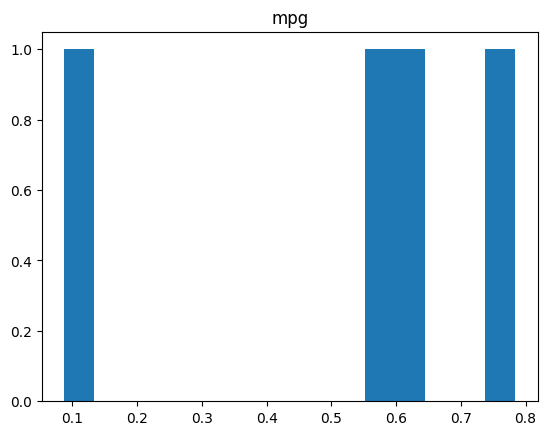

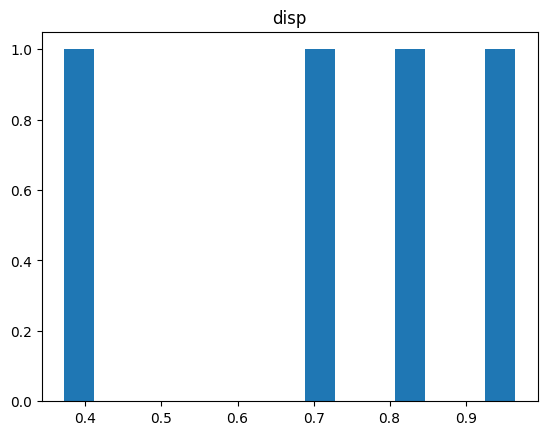

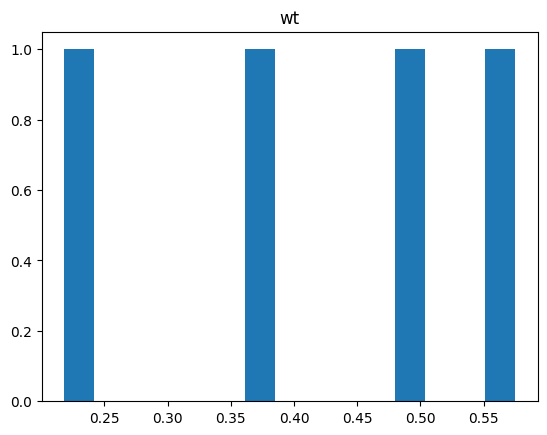

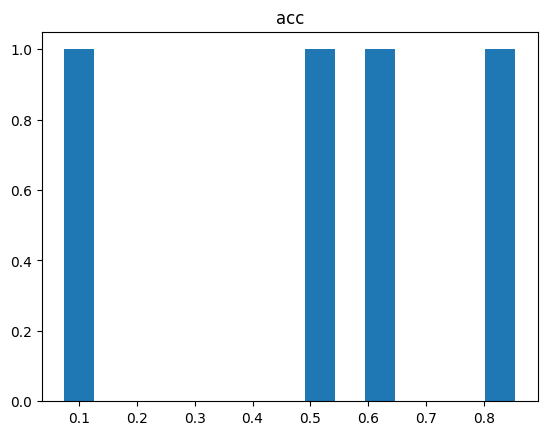

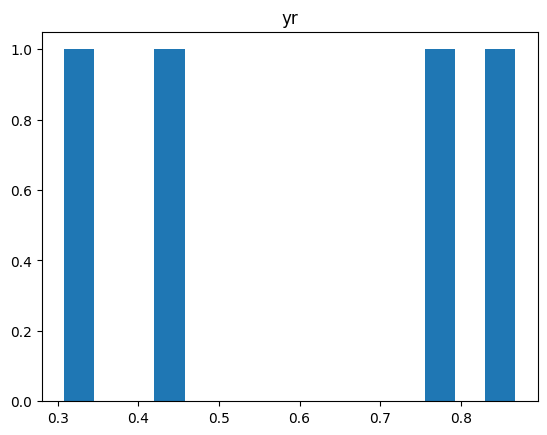

In [20]:
df_updated = pd.DataFrame(data = np.random.random(size=(4,5)), columns = ['mpg','disp','wt','acc','yr'])
for column in df_updated:
  plt.figure()
  plt.hist(df_updated[column],bins=15)
  plt.title(column)

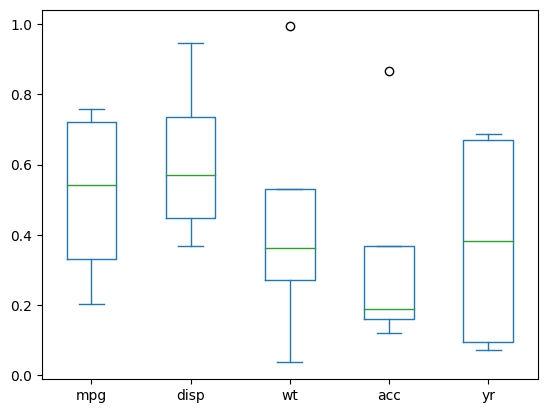

In [21]:
df_updated = pd.DataFrame(data = np.random.random(size=(4,5)), columns = ['mpg','disp','wt','acc','yr'])
df_updated.plot(kind='box')
plt.show()

From the boxplot above, We can see that mpg has outlier. On axis level, the values of mpg are very high indicating that most of the cars provide high mpg. It is rightly skewed.
The displacement and acceleration of the cars are widely spread across big range. The weight is rightly skewed.

Part 1.2 a - Check and print feature-wise percentage of missing values present in the data and impute with the best suitable approach.

In [22]:
df_merged.shape

(398, 10)

In [23]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    object 
 1   ID        398 non-null    int64  
 2   mpg       398 non-null    float64
 3   cyl       398 non-null    int64  
 4   disp      398 non-null    float64
 5   hp        398 non-null    object 
 6   wt        398 non-null    int64  
 7   acc       398 non-null    float64
 8   yr        398 non-null    int64  
 9   origin    398 non-null    int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 34.2+ KB


In [24]:
percent_missing = df_merged.isnull().sum() * 100 / len(df_merged)
missing_value_df = pd.DataFrame({'column_name': df_merged.columns,
                                 'percent_missing': percent_missing})
print(missing_value_df)

         column_name  percent_missing
car_name    car_name         0.000000
ID                ID         0.000000
mpg              mpg         0.000000
cyl              cyl         0.000000
disp            disp         0.000000
hp                hp         0.000000
wt                wt         0.000000
acc              acc         0.000000
yr                yr         0.000000
origin        origin         0.000000


In [25]:
df_merged.isna().sum()

car_name    0
ID          0
mpg         0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
origin      0
dtype: int64

There is no missing data in this dataset and hence no imputation is required

2.B. Check for duplicate values in the data and impute with the best suitable approach

In [26]:
for col in df_merged.columns:
  boolean = df_merged[col].duplicated().any()
  print("duplicate values present in",col, ":", boolean)

duplicate values present in car_name : True
duplicate values present in ID : False
duplicate values present in mpg : True
duplicate values present in cyl : True
duplicate values present in disp : True
duplicate values present in hp : True
duplicate values present in wt : True
duplicate values present in acc : True
duplicate values present in yr : True
duplicate values present in origin : True


2.C. Plot a pairplot for all features

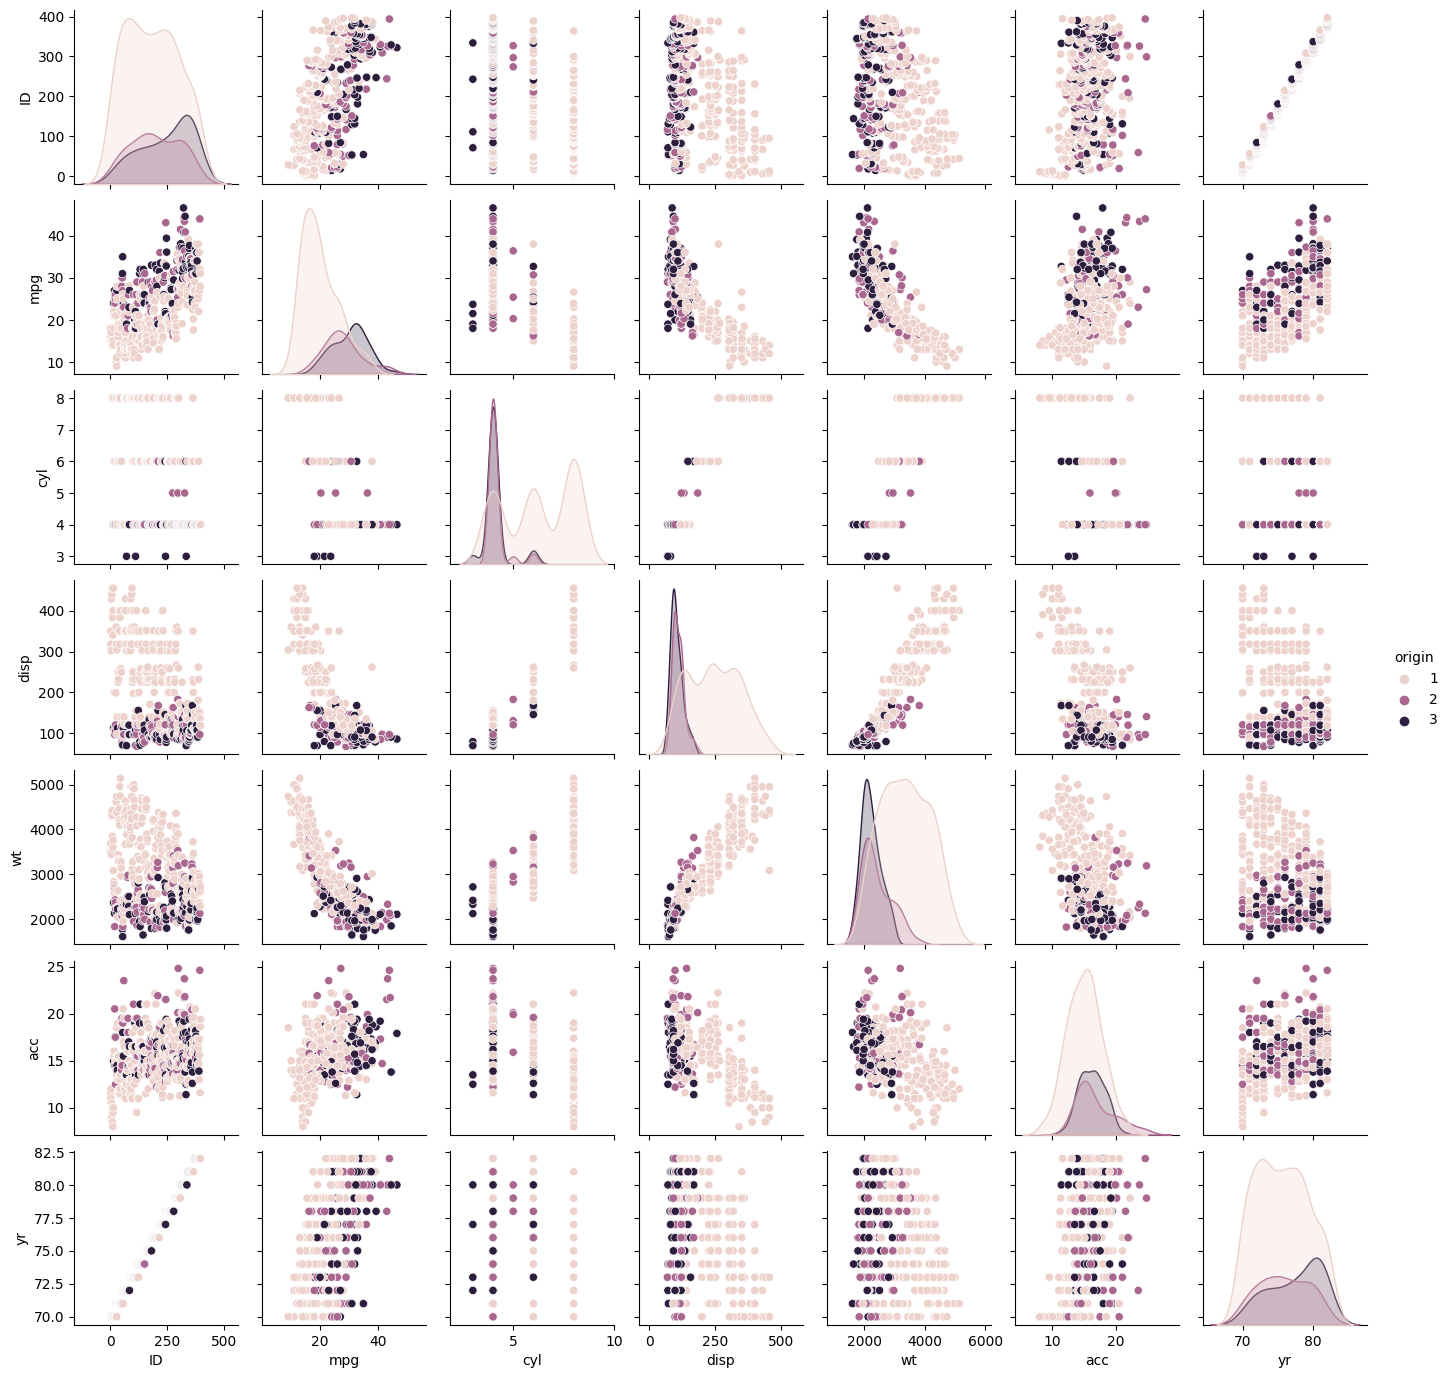

In [27]:
sns.pairplot(df_merged, hue ='origin', height=2)

weight and displacement has positive correlation
weight and mpg has negative correlation
displacement and mpg has negative correlation
weight and mpg has negative correlation

Others have a very linear or one to one correlation


2.D. Visualize a scatterplot for ‘wt’ and ‘disp’. Datapoints should be distinguishable by ‘cyl’

<Axes: xlabel='wt', ylabel='disp'>

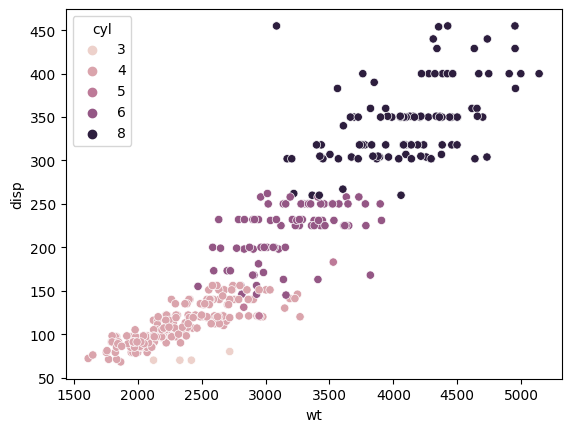

In [28]:
sns.scatterplot(x = "wt", y = "disp", data = df_merged, hue = "cyl")

1.2 e - Share insights for Q2.d.

We can see that there is positive relation between weight and displacement. As the weight of the car increases, displacement increases linearly

1.2 f - Visualize a scatterplot for ‘wt’ and ’mpg’. Datapoints should be distinguishable by ‘cyl’.

<Axes: xlabel='wt', ylabel='mpg'>

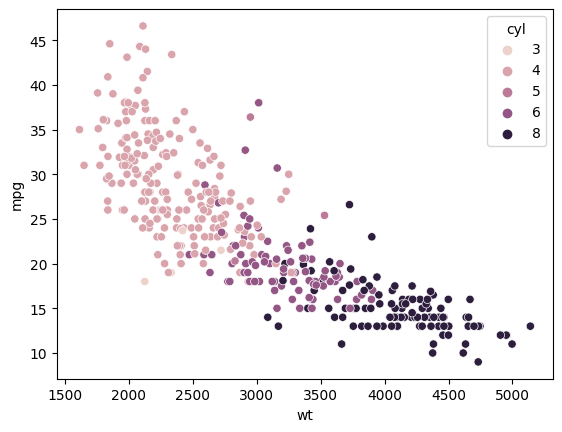

In [29]:
sns.scatterplot(x = "wt", y = "mpg", data = df_merged, hue = "cyl")

 1.2 g- Share insights for Q2.f.

We can see that there is negative relation between weight and mpg. As the weight increases, mpg decreases linearly

1.2 h - Check for unexpected values in all the features and datapoints with such values.

In [30]:
df_merged['hp'].unique()

array([130, 165, 150, 140, 198, 220, 215, 225, 190, 170, 160, 95, 97, 85,
       88, 46, 87, 90, 113, 200, 210, 193, '?', 100, 105, 175, 153, 180,
       110, 72, 86, 70, 76, 65, 69, 60, 80, 54, 208, 155, 112, 92, 145,
       137, 158, 167, 94, 107, 230, 49, 75, 91, 122, 67, 83, 78, 52, 61,
       93, 148, 129, 96, 71, 98, 115, 53, 81, 79, 120, 152, 102, 108, 68,
       58, 149, 89, 63, 48, 66, 139, 103, 125, 133, 138, 135, 142, 77, 62,
       132, 84, 64, 74, 116, 82], dtype=object)

hp column does have ? value

In [31]:
df_merged['mpg'].unique()

array([18. , 15. , 16. , 17. , 14. , 24. , 22. , 21. , 27. , 26. , 25. ,
       10. , 11. ,  9. , 28. , 19. , 12. , 13. , 23. , 30. , 31. , 35. ,
       20. , 29. , 32. , 33. , 17.5, 15.5, 14.5, 22.5, 24.5, 18.5, 29.5,
       26.5, 16.5, 31.5, 36. , 25.5, 33.5, 20.5, 30.5, 21.5, 43.1, 36.1,
       32.8, 39.4, 19.9, 19.4, 20.2, 19.2, 25.1, 20.6, 20.8, 18.6, 18.1,
       17.7, 27.5, 27.2, 30.9, 21.1, 23.2, 23.8, 23.9, 20.3, 21.6, 16.2,
       19.8, 22.3, 17.6, 18.2, 16.9, 31.9, 34.1, 35.7, 27.4, 25.4, 34.2,
       34.5, 31.8, 37.3, 28.4, 28.8, 26.8, 41.5, 38.1, 32.1, 37.2, 26.4,
       24.3, 19.1, 34.3, 29.8, 31.3, 37. , 32.2, 46.6, 27.9, 40.8, 44.3,
       43.4, 36.4, 44.6, 40.9, 33.8, 32.7, 23.7, 23.6, 32.4, 26.6, 25.8,
       23.5, 39.1, 39. , 35.1, 32.3, 37.7, 34.7, 34.4, 29.9, 33.7, 32.9,
       31.6, 28.1, 30.7, 24.2, 22.4, 34. , 38. , 44. ])

mpg has only float numbers

In [32]:
df_merged['cyl'].unique()

array([8, 4, 6, 3, 5])

cylinder column has only integers

In [33]:
df_merged['disp'].unique()

array([307. , 350. , 318. , 304. , 302. , 429. , 454. , 440. , 455. ,
       390. , 383. , 340. , 400. , 113. , 198. , 199. , 200. ,  97. ,
       110. , 107. , 104. , 121. , 360. , 140. ,  98. , 232. , 225. ,
       250. , 351. , 258. , 122. , 116. ,  79. ,  88. ,  71. ,  72. ,
        91. ,  97.5,  70. , 120. ,  96. , 108. , 155. ,  68. , 114. ,
       156. ,  76. ,  83. ,  90. , 231. , 262. , 134. , 119. , 171. ,
       115. , 101. , 305. ,  85. , 130. , 168. , 111. , 260. , 151. ,
       146. ,  80. ,  78. , 105. , 131. , 163. ,  89. , 267. ,  86. ,
       183. , 141. , 173. , 135. ,  81. , 100. , 145. , 112. , 181. ,
       144. ])

displacement column has only integers

In [34]:
df_merged['acc'].unique()

array([12. , 11.5, 11. , 10.5, 10. ,  9. ,  8.5,  8. ,  9.5, 15. , 15.5,
       16. , 14.5, 20.5, 17.5, 12.5, 14. , 13.5, 18.5, 19. , 13. , 19.5,
       18. , 17. , 23.5, 16.5, 21. , 16.9, 14.9, 17.7, 15.3, 13.9, 12.8,
       15.4, 17.6, 22.2, 22.1, 14.2, 17.4, 16.2, 17.8, 12.2, 16.4, 13.6,
       15.7, 13.2, 21.9, 16.7, 12.1, 14.8, 18.6, 16.8, 13.7, 11.1, 11.4,
       18.2, 15.8, 15.9, 14.1, 21.5, 14.4, 19.4, 19.2, 17.2, 18.7, 15.1,
       13.4, 11.2, 14.7, 16.6, 17.3, 15.2, 14.3, 20.1, 24.8, 11.3, 12.9,
       18.8, 18.1, 17.9, 21.7, 23.7, 19.9, 21.8, 13.8, 12.6, 16.1, 20.7,
       18.3, 20.4, 19.6, 17.1, 15.6, 24.6, 11.6])

acceleration column only has float numbers

In [35]:
df_merged['yr'].unique()

array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

year column has only integers

In [36]:
df_merged['origin'].unique()

array([1, 3, 2])

origin column has only integers

In [37]:
df_merged['car_name'].unique()

array(['chevrolet chevelle malibu', 'buick skylark 320',
       'plymouth satellite', 'amc rebel sst', 'ford torino',
       'ford galaxie 500', 'chevrolet impala', 'plymouth fury iii',
       'pontiac catalina', 'amc ambassador dpl', 'dodge challenger se',
       "plymouth 'cuda 340", 'chevrolet monte carlo',
       'buick estate wagon (sw)', 'toyota corona mark ii',
       'plymouth duster', 'amc hornet', 'ford maverick', 'datsun pl510',
       'volkswagen 1131 deluxe sedan', 'peugeot 504', 'audi 100 ls',
       'saab 99e', 'bmw 2002', 'amc gremlin', 'ford f250', 'chevy c20',
       'dodge d200', 'hi 1200d', 'chevrolet vega 2300', 'toyota corona',
       'ford pinto', 'plymouth satellite custom', 'ford torino 500',
       'amc matador', 'pontiac catalina brougham', 'dodge monaco (sw)',
       'ford country squire (sw)', 'pontiac safari (sw)',
       'amc hornet sportabout (sw)', 'chevrolet vega (sw)',
       'pontiac firebird', 'ford mustang', 'mercury capri 2000',
       'opel 1900'

In [38]:
df_merged['car_name'] = df_merged['car_name'].astype('|S')

In [39]:
df_merged['car_name'].dtype

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   car_name  398 non-null    |S36   
 1   ID        398 non-null    int64  
 2   mpg       398 non-null    float64
 3   cyl       398 non-null    int64  
 4   disp      398 non-null    float64
 5   hp        398 non-null    object 
 6   wt        398 non-null    int64  
 7   acc       398 non-null    float64
 8   yr        398 non-null    int64  
 9   origin    398 non-null    int64  
dtypes: bytes288(1), float64(3), int64(5), object(1)
memory usage: 45.1+ KB


In [40]:
df_car_attributes = df_merged.replace('?', np.nan)

df_car_attributes['hp'].unique()


array([130., 165., 150., 140., 198., 220., 215., 225., 190., 170., 160.,
        95.,  97.,  85.,  88.,  46.,  87.,  90., 113., 200., 210., 193.,
        nan, 100., 105., 175., 153., 180., 110.,  72.,  86.,  70.,  76.,
        65.,  69.,  60.,  80.,  54., 208., 155., 112.,  92., 145., 137.,
       158., 167.,  94., 107., 230.,  49.,  75.,  91., 122.,  67.,  83.,
        78.,  52.,  61.,  93., 148., 129.,  96.,  71.,  98., 115.,  53.,
        81.,  79., 120., 152., 102., 108.,  68.,  58., 149.,  89.,  63.,
        48.,  66., 139., 103., 125., 133., 138., 135., 142.,  77.,  62.,
       132.,  84.,  64.,  74., 116.,  82.])

In [41]:
df_car_attributes.shape

(398, 10)

In [42]:
df_car_attributes.head()

,car_name,ID,mpg,cyl,disp,hp,wt,acc,yr,origin
0,b'chevrolet chevelle malibu',0,18.000000,8,307.000000,130.000000,3504,12.000000,70,1
1,b'buick skylark 320',1,15.000000,8,350.000000,165.000000,3693,11.500000,70,1
2,b'plymouth satellite',2,18.000000,8,318.000000,150.000000,3436,11.000000,70,1
3,b'amc rebel sst',3,16.000000,8,304.000000,150.000000,3433,12.000000,70,1
4,b'ford torino',4,17.000000,8,302.000000,140.000000,3449,10.500000,70,1


In [43]:
#dropping car_name as we can apply imputing on numerical values only
df2= df_car_attributes.drop('car_name', axis=1)
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
results = pd.DataFrame(mean_imputer.fit_transform(df2),columns = df2.columns)

In [44]:
df_car_name=df_car_attributes.pop('car_name')

#z-score is applied for normalising the data
results = results.apply(zscore)

df_car_attributes = results.join(df_car_name)
df_car_attributes.head()

,ID,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name
0,-1.727704,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,b'chevrolet chevelle malibu'
1,-1.719001,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,b'buick skylark 320'
2,-1.710297,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,b'plymouth satellite'
3,-1.701593,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,b'amc rebel sst'
4,-1.692889,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,b'ford torino'


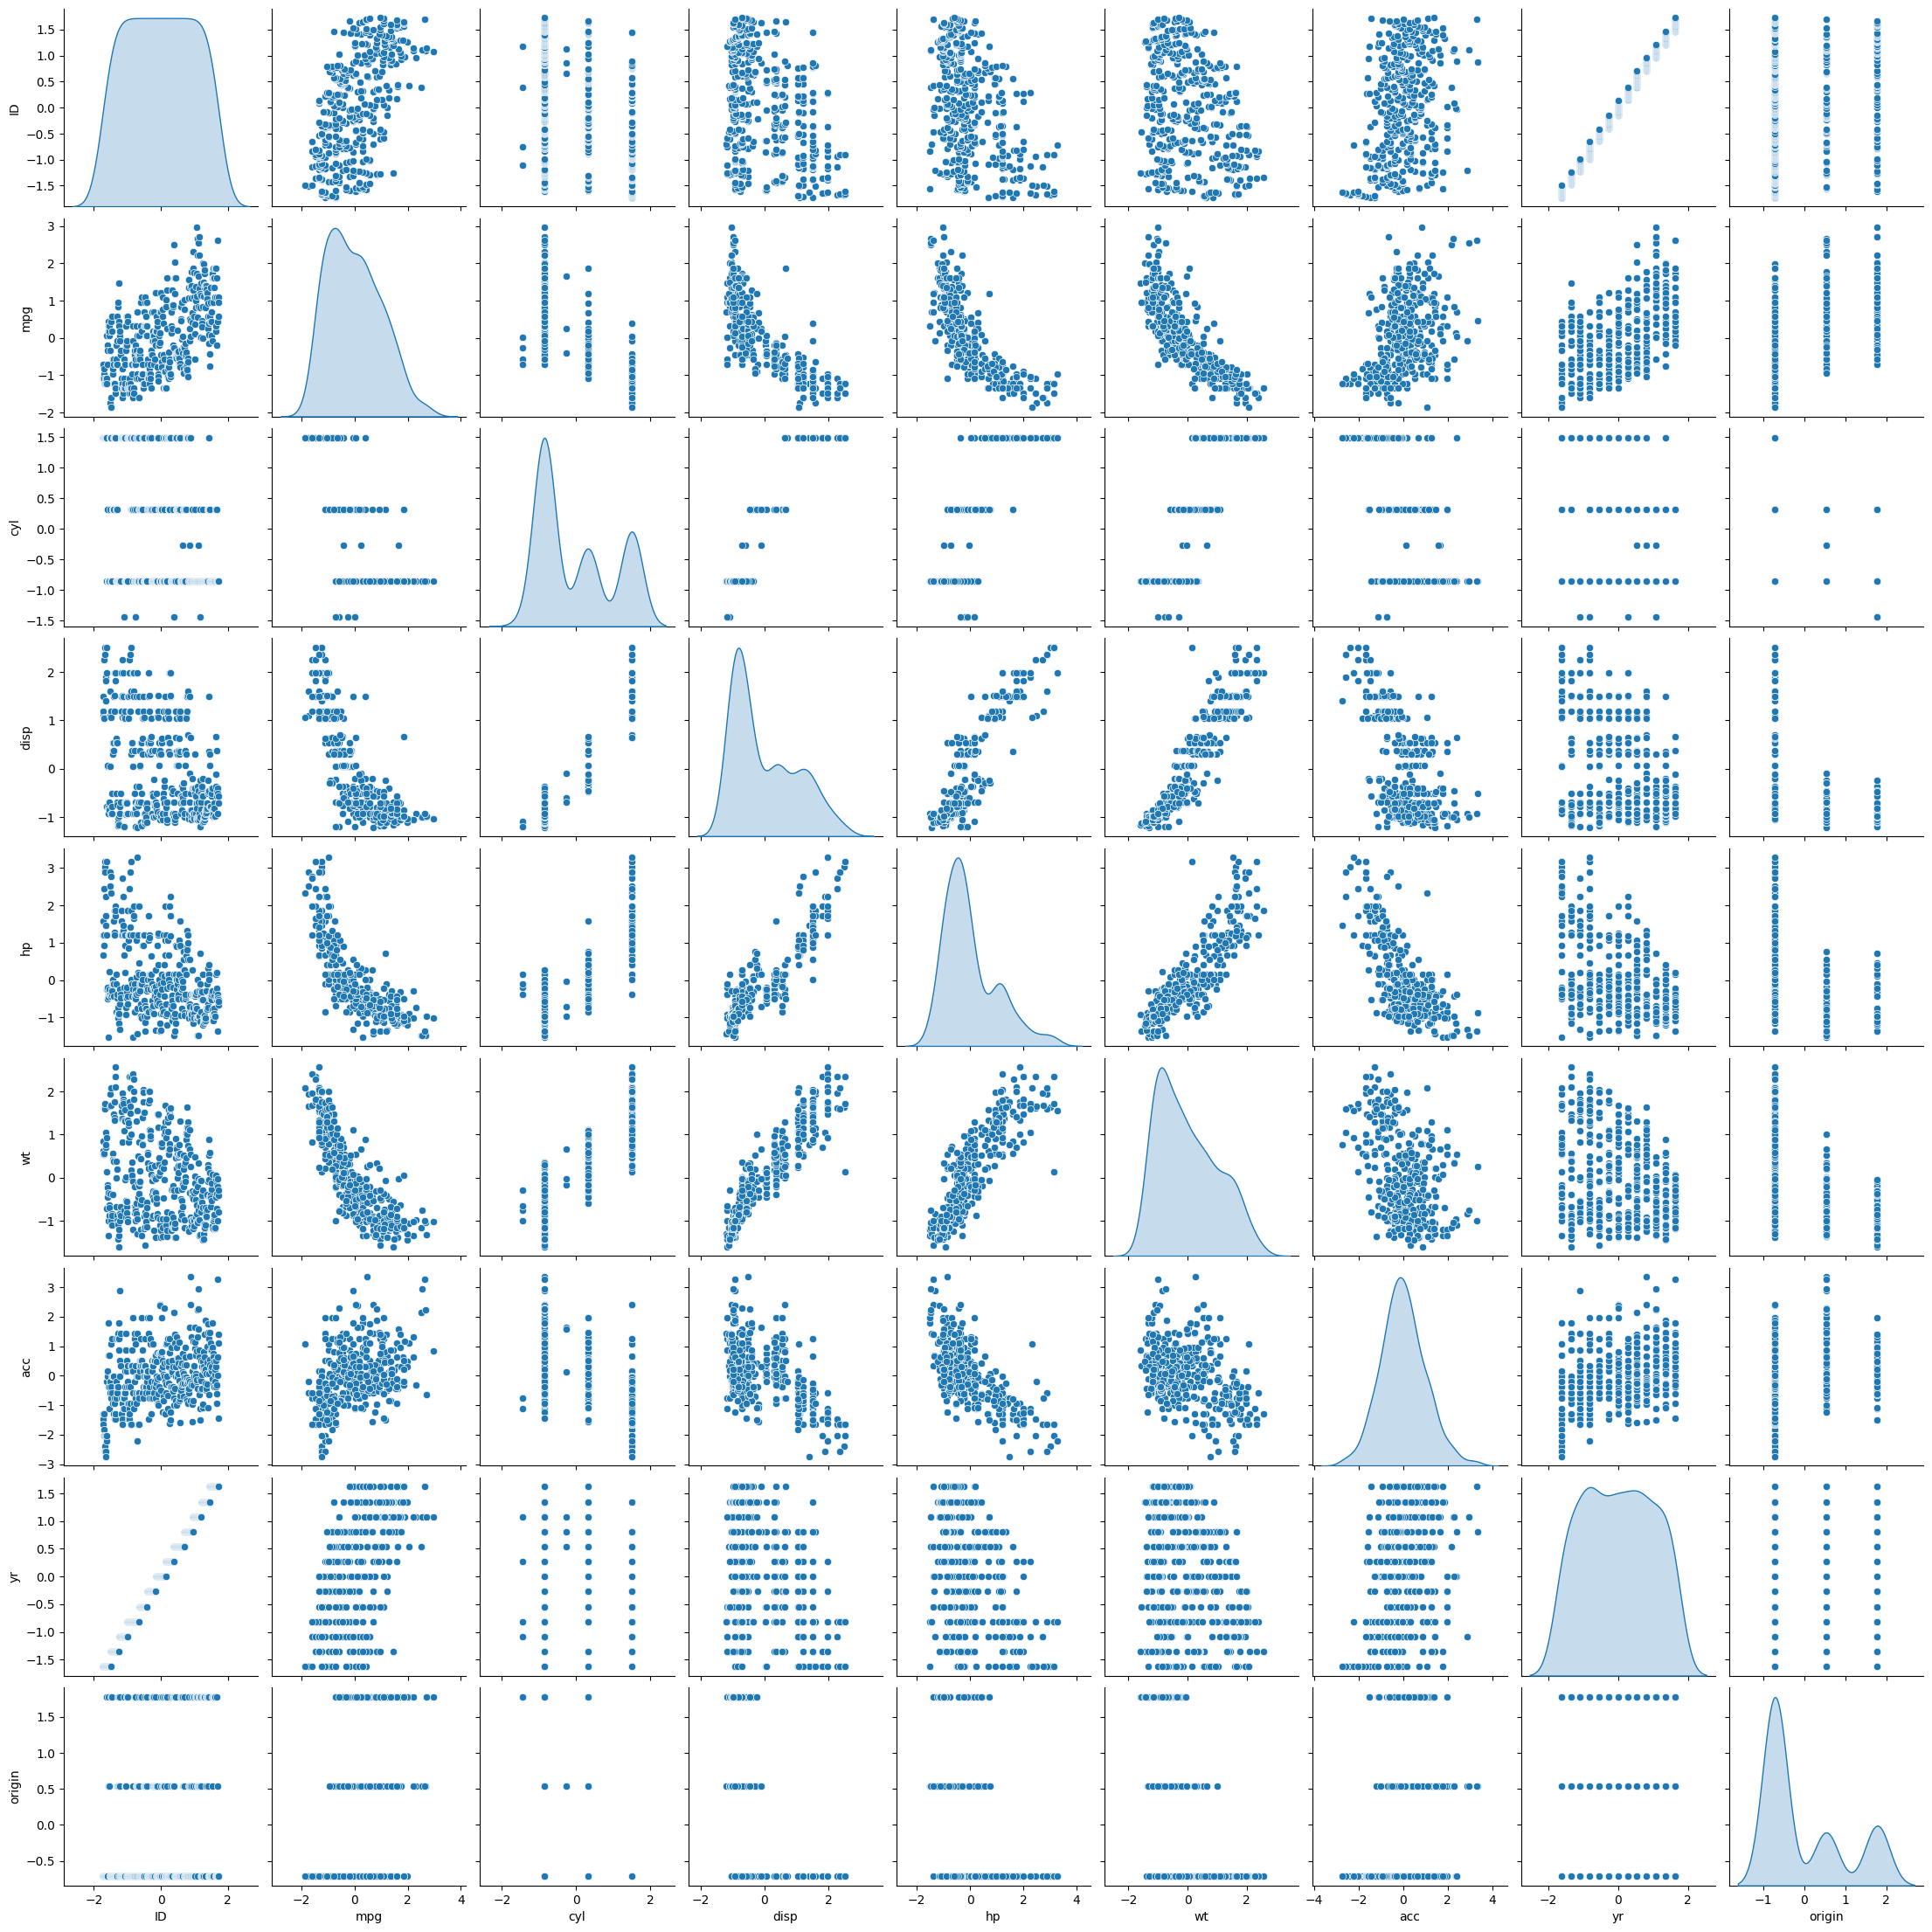

In [45]:
sns.pairplot(results, diag_kind='kde')

Overview of correlation between all parameters using scatter plot

1.3 a -Apply K-Means clustering for 2 to 10 clusters

In [46]:
clusters=range(2,10)
meanDistortions=[]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

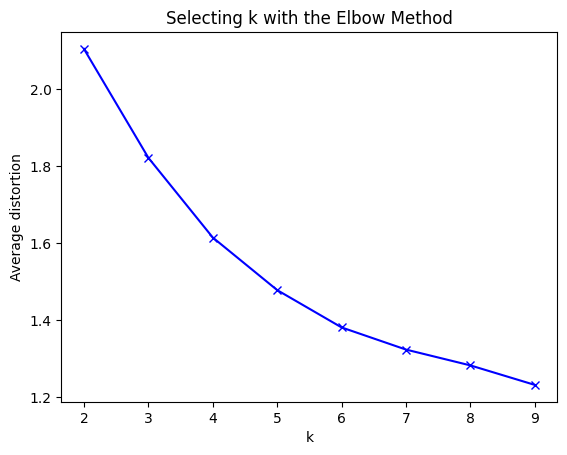

In [47]:
df_for_kmeans = df_car_attributes.drop('car_name',axis=1)

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(df_for_kmeans)
    prediction=model.predict(df_for_kmeans)
    meanDistortions.append(sum(np.min(cdist(df_for_kmeans, model.cluster_centers_, 'euclidean'), axis=1)) / df_for_kmeans.shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

3.C. On the above visual, highlight which are the possible Elbow points

From the above curve, we can see that bend is coming clearly at k=4. We can look at it in detail

In [48]:
df_for_kmeans.shape

(398, 9)

In [49]:
df_for_kmeans.head()

,ID,mpg,cyl,disp,hp,wt,acc,yr,origin
0,-1.727704,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145
1,-1.719001,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145
2,-1.710297,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145
3,-1.701593,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145
4,-1.692889,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145


3.D. Train a K-means clustering model once again on the optimal number of clusters

In [50]:
# Let us first start with K = 4
final_model=KMeans(4)
final_model.fit(df_for_kmeans)
prediction=final_model.predict(df_for_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3.E Add a new feature in the DataFrame which will have labels based upon cluster value

In [51]:
#Append the prediction
df_car_attributes["Group"] = prediction
print("Groups Assigned : \n")
df_car_attributes[["car_name", "Group"]]

Groups Assigned : 



,car_name,Group
0,b'chevrolet chevelle malibu',3
1,b'buick skylark 320',3
2,b'plymouth satellite',3
3,b'amc rebel sst',3
4,b'ford torino',3
...,...,...
393,b'ford mustang gl',2
394,b'vw pickup',2
395,b'dodge rampage',2
396,b'ford ranger',2


In [52]:
df_car_attributes.shape

(398, 11)

In [53]:
df_car_attributes.head()

,ID,mpg,cyl,disp,hp,wt,acc,yr,origin,car_name,Group
0,-1.727704,-0.706439,1.498191,1.090604,0.673118,0.630870,-1.295498,-1.627426,-0.715145,b'chevrolet chevelle malibu',3
1,-1.719001,-1.090751,1.498191,1.503514,1.589958,0.854333,-1.477038,-1.627426,-0.715145,b'buick skylark 320',3
2,-1.710297,-0.706439,1.498191,1.196232,1.197027,0.550470,-1.658577,-1.627426,-0.715145,b'plymouth satellite',3
3,-1.701593,-0.962647,1.498191,1.061796,1.197027,0.546923,-1.295498,-1.627426,-0.715145,b'amc rebel sst',3
4,-1.692889,-0.834543,1.498191,1.042591,0.935072,0.565841,-1.840117,-1.627426,-0.715145,b'ford torino',3


3.F. Plot a visual and color the datapoints based upon clusters

array([[<Axes: title={'center': 'ID'}, xlabel='[Group]'>,
        <Axes: title={'center': 'acc'}, xlabel='[Group]'>,
        <Axes: title={'center': 'cyl'}, xlabel='[Group]'>],
       [<Axes: title={'center': 'disp'}, xlabel='[Group]'>,
        <Axes: title={'center': 'hp'}, xlabel='[Group]'>,
        <Axes: title={'center': 'mpg'}, xlabel='[Group]'>],
       [<Axes: title={'center': 'origin'}, xlabel='[Group]'>,
        <Axes: title={'center': 'wt'}, xlabel='[Group]'>,
        <Axes: title={'center': 'yr'}, xlabel='[Group]'>]], dtype=object)

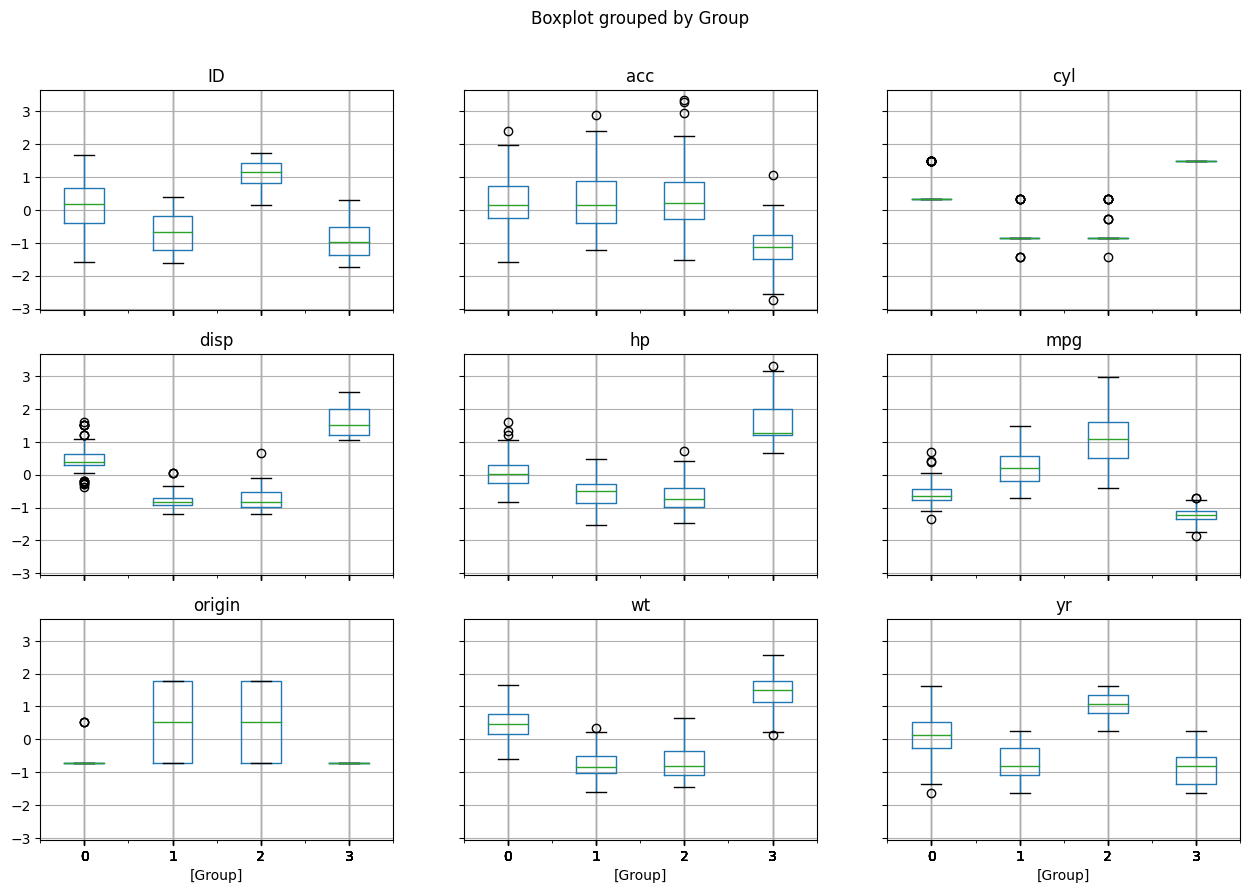

In [54]:
df_car_attributes.boxplot(by='Group', layout=(3,3), figsize=(15,10))

From the above boxplot, we can see many outliers for many parameters across groups.
We can also see that Group 1 & 2 has car weighing less.
Most of the cars have origin in Group 1 & 2.
The mpg of cars in Group 1 & 2 is high.

In [55]:
df_car_attributes['Group'].value_counts()

2    124
1     99
0     94
3     81
Name: Group, dtype: int64

3.G.Pass a new DataPoint and predict which cluster it belongs to.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

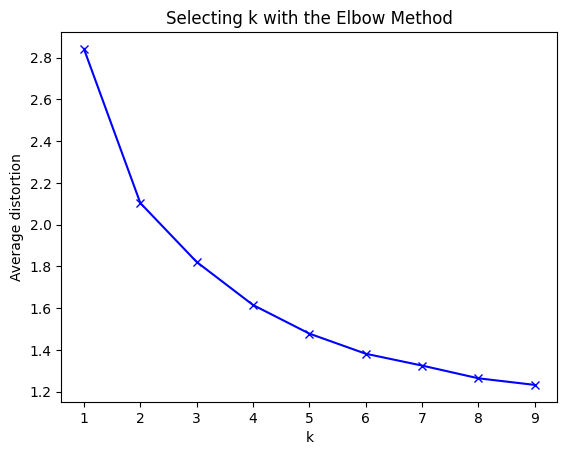

In [56]:
clusters_new=range(1,10)
meanDistortions=[]

#df_for_kmeans_new = df_car_attributes.drop('car_name',axis=1)

for k in clusters_new:
    model=KMeans(n_clusters=k)
    model.fit(df_for_kmeans)
    prediction=model.predict(df_for_kmeans)
    meanDistortions.append(sum(np.min(cdist(df_for_kmeans, model.cluster_centers_, 'euclidean'), axis=1)) / df_for_kmeans.shape[0])


plt.plot(clusters_new, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

In [57]:
#selecting k=3
final_model=KMeans(3)
final_model.fit(df_for_kmeans)
prediction=final_model.predict(df_for_kmeans)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
df_car_attributes["Group"] = prediction
print("Groups Assigned : \n")
df_car_attributes[["car_name", "Group"]]

Groups Assigned : 



,car_name,Group
0,b'chevrolet chevelle malibu',1
1,b'buick skylark 320',1
2,b'plymouth satellite',1
3,b'amc rebel sst',1
4,b'ford torino',1
...,...,...
393,b'ford mustang gl',0
394,b'vw pickup',0
395,b'dodge rampage',0
396,b'ford ranger',0


We can see that the groups have changed

 PART B - PROJECT OBJECTIVE: Apply dimensionality reduction technique – PCA and train a model and compare relative results.

1. Data Understanding & Cleaning:

A. Read ‘vehicle.csv’ and save as DataFrame

In [59]:
%cd /content/gdrive/My Drive/Colab Notebooks/

df_vehicle = pd.read_csv('vehicle.csv')

/content/gdrive/My Drive/Colab Notebooks


In [60]:
df_vehicle.shape

(846, 19)

In [61]:
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [62]:
df_vehicle.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.000000,83.000000,178.000000,72.000000,10,162.000000,42.000000,20.000000,159,176.000000,379.000000,184.000000,70.000000,6.000000,16.000000,187.000000,197,van
1,91,41.000000,84.000000,141.000000,57.000000,9,149.000000,45.000000,19.000000,143,170.000000,330.000000,158.000000,72.000000,9.000000,14.000000,189.000000,199,van
2,104,50.000000,106.000000,209.000000,66.000000,10,207.000000,32.000000,23.000000,158,223.000000,635.000000,220.000000,73.000000,14.000000,9.000000,188.000000,196,car
3,93,41.000000,82.000000,159.000000,63.000000,9,144.000000,46.000000,19.000000,143,160.000000,309.000000,127.000000,63.000000,6.000000,10.000000,199.000000,207,van
4,85,44.000000,70.000000,205.000000,103.000000,52,149.000000,45.000000,19.000000,144,241.000000,325.000000,188.000000,127.000000,9.000000,11.000000,180.000000,183,bus


B. Check percentage of missing values and impute with correct approach

In [63]:
percent_missing_vehicles = df_vehicle.isnull().sum() * 100 / len(df_vehicle)
missing_value_df_vehicle = pd.DataFrame({'column_name': df_vehicle.columns,
                                 'percent_missing': percent_missing_vehicles})
print(missing_value_df_vehicle)

                                             column_name  percent_missing
compactness                                  compactness         0.000000
circularity                                  circularity         0.591017
distance_circularity                distance_circularity         0.472813
radius_ratio                                radius_ratio         0.709220
pr.axis_aspect_ratio                pr.axis_aspect_ratio         0.236407
max.length_aspect_ratio          max.length_aspect_ratio         0.000000
scatter_ratio                              scatter_ratio         0.118203
elongatedness                              elongatedness         0.118203
pr.axis_rectangularity            pr.axis_rectangularity         0.354610
max.length_rectangularity      max.length_rectangularity         0.000000
scaled_variance                          scaled_variance         0.354610
scaled_variance.1                      scaled_variance.1         0.236407
scaled_radius_of_gyration      scaled_

In [64]:
for cols in df_vehicle:
  if(cols != 'class'):
    df_vehicle[cols]= df_vehicle[cols].fillna(df_vehicle[cols].median())

In [65]:
percent_missing_vehicles = df_vehicle.isnull().sum() * 100 / len(df_vehicle)
missing_value_df_vehicle = pd.DataFrame({'column_name': df_vehicle.columns,
                                 'percent_missing': percent_missing_vehicles})
print(missing_value_df_vehicle)

                                             column_name  percent_missing
compactness                                  compactness         0.000000
circularity                                  circularity         0.000000
distance_circularity                distance_circularity         0.000000
radius_ratio                                radius_ratio         0.000000
pr.axis_aspect_ratio                pr.axis_aspect_ratio         0.000000
max.length_aspect_ratio          max.length_aspect_ratio         0.000000
scatter_ratio                              scatter_ratio         0.000000
elongatedness                              elongatedness         0.000000
pr.axis_rectangularity            pr.axis_rectangularity         0.000000
max.length_rectangularity      max.length_rectangularity         0.000000
scaled_variance                          scaled_variance         0.000000
scaled_variance.1                      scaled_variance.1         0.000000
scaled_radius_of_gyration      scaled_

1.c.Visualize a Pie-chart and print percentage of values for variable ‘class’

In [66]:
df_vehicle['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

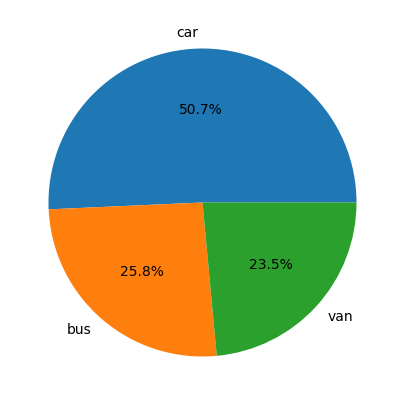

In [67]:
my_labels = 'car', 'bus', 'van'

ax = df_vehicle['class'].value_counts().plot(kind='pie', figsize=(5,5), autopct='%1.1f%%', labels=my_labels)
ax.axes.get_yaxis().set_visible(False)


1.D. Check for duplicate rows in the data and impute with correct approach

In [68]:
print("Duplicated rows: ", df_vehicle[df_vehicle.duplicated()].shape[0])

Duplicated rows:  0


2. Data Preparation:

2.A. Split data into X and Y.

In [69]:
X = df_vehicle.drop('class', axis=1)
Y = df_vehicle['class']

2.B. Standardize the Data.

In [70]:
X_std = pd.DataFrame(StandardScaler().fit_transform(X))
X_std.columns = X.columns

X_std.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,0.160580,0.518073,0.057177,0.273363,1.310398,0.311542,-0.207598,0.136262,-0.224342,0.758332,-0.401920,-0.341934,0.285705,-0.327326,-0.073812,0.380870,-0.312012,0.183957
1,-0.325470,-0.623732,0.120741,-0.835032,-0.593753,0.094079,-0.599423,0.520519,-0.610886,-0.344578,-0.593357,-0.619724,-0.513630,-0.059384,0.538390,0.156798,0.013265,0.452977
2,1.254193,0.844303,1.519141,1.202018,0.548738,0.311542,1.148719,-1.144597,0.935290,0.689401,1.097671,1.109379,1.392477,0.074587,1.558727,-0.403383,-0.149374,0.049447
3,-0.082445,-0.623732,-0.006386,-0.295813,0.167907,0.094079,-0.750125,0.648605,-0.610886,-0.344578,-0.912419,-0.738777,-1.466683,-1.265121,-0.073812,-0.291347,1.639649,1.529056
4,-1.054545,-0.134387,-0.769150,1.082192,5.245643,9.444962,-0.599423,0.520519,-0.610886,-0.275646,1.671982,-0.648070,0.408680,7.309005,0.538390,-0.179311,-1.450481,-1.699181


3. Model Building:

3.A. Train a base Classification model using SVM.

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_std, Y, test_size=0.25, random_state=100)

print("Number of records after splitting X train: ", X_train.shape)
print("Number of records after splitting X test: ", X_test.shape)
print("Number of records after splitting y train: ", y_train.shape)
print("Number of records after splitting y test: ", y_test.shape)

Number of records after splitting X train:  (634, 18)
Number of records after splitting X test:  (212, 18)
Number of records after splitting y train:  (634,)
Number of records after splitting y test:  (212,)


In [72]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

In [73]:
accuracy = svm_model.score(X_test,y_test)
print(accuracy)

0.9575471698113207


Accuracy of the SVM model using test data set is 95%

3.B. Print Classification metrics for train data

In [74]:
y_pred=svm_model.predict(X_test)

print("Classification report for test data")
print(metrics.classification_report(y_test,y_pred))


Classification report for test data
              precision    recall  f1-score   support

         bus       0.95      0.98      0.96        56
         car       0.98      0.94      0.96       103
         van       0.93      0.96      0.94        53

    accuracy                           0.96       212
   macro avg       0.95      0.96      0.96       212
weighted avg       0.96      0.96      0.96       212



In [75]:
print("Confusion matrix for test data")
metrics.confusion_matrix(y_test,y_pred)

Confusion matrix for test data


array([[55,  0,  1],
       [ 3, 97,  3],
       [ 0,  2, 51]])

3.C.Apply PCA on the data with 10 components

In [76]:
covMatrix = np.cov(X_std, rowvar=False)
pd.DataFrame(covMatrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.001183,0.685698,0.790863,0.690560,0.091643,0.148425,0.813582,-0.789683,0.814657,0.676943,0.762972,0.814976,0.585935,-0.249888,0.236358,0.157200,0.298890,0.365984
1,0.685698,1.001183,0.793258,0.621647,0.153960,0.251764,0.848941,-0.822444,0.844398,0.962456,0.797248,0.836935,0.926912,0.052008,0.144368,-0.011452,-0.104550,0.046406
2,0.790863,0.793258,1.001183,0.767942,0.158643,0.265000,0.906147,-0.912385,0.894082,0.775444,0.862539,0.887066,0.706607,-0.226211,0.114059,0.265861,0.146271,0.333126
3,0.690560,0.621647,0.767942,1.001183,0.664232,0.450584,0.735298,-0.790416,0.709224,0.569623,0.794354,0.719286,0.537007,-0.180611,0.048770,0.173946,0.382666,0.471867
4,0.091643,0.153960,0.158643,0.664232,1.001183,0.649491,0.103855,-0.183252,0.079698,0.127059,0.273233,0.089294,0.122115,0.153131,-0.058440,-0.032014,0.240170,0.268042
5,0.148425,0.251764,0.265000,0.450584,0.649491,1.001183,0.166388,-0.180353,0.161693,0.306305,0.319334,0.143423,0.189967,0.296085,0.015618,0.043473,-0.026111,0.144089
6,0.813582,0.848941,0.906147,0.735298,0.103855,0.166388,1.001183,-0.972751,0.990922,0.810041,0.949785,0.994187,0.800821,-0.027574,0.074546,0.212680,0.005634,0.118958
7,-0.789683,-0.822444,-0.912385,-0.790416,-0.183252,-0.180353,-0.972751,1.001183,-0.950119,-0.776772,-0.937490,-0.954945,-0.767221,0.103424,-0.052662,-0.185272,-0.115262,-0.217161
8,0.814657,0.844398,0.894082,0.709224,0.079698,0.161693,0.990922,-0.950119,1.001183,0.811893,0.935333,0.989383,0.797632,-0.015514,0.083866,0.214955,-0.018671,0.099404
9,0.676943,0.962456,0.775444,0.569623,0.127059,0.306305,0.810041,-0.776772,0.811893,1.001183,0.745866,0.795555,0.867476,0.041671,0.136012,0.001367,-0.104071,0.076860


In [77]:
e_vals, e_vecs =np.linalg.eig(covMatrix)
print('Eigen Vectors \n%s' ,  e_vecs)
print('\nEigen Values \n%s' ,  e_vals)


Eigen Vectors 
%s [[ 2.75283688e-01  1.26953763e-01 -1.19922479e-01  7.83843562e-02
   6.95178336e-02 -1.44875476e-01 -4.51862331e-01 -5.66136785e-01
  -4.84418105e-01 -2.60076393e-01  4.65342885e-02 -1.20344026e-02
  -1.56136836e-01 -1.00728764e-02 -6.00532537e-03  6.00485194e-02
  -6.50956666e-02 -9.67780251e-03]
 [ 2.93258469e-01 -1.25576727e-01 -2.48205467e-02  1.87337408e-01
  -8.50649539e-02  3.02731148e-01  2.49103387e-01 -1.79851809e-01
  -1.41569001e-02  9.80779086e-02  3.01323693e-03  2.13635088e-01
  -1.50116709e-02 -9.15939674e-03  7.38059396e-02 -4.26993118e-01
  -2.61244802e-01 -5.97862837e-01]
 [ 3.04609128e-01  7.29516436e-02 -5.60143254e-02 -7.12008427e-02
   4.06645651e-02  1.38405773e-01 -7.40350569e-02  4.34748988e-01
  -1.67572478e-01 -2.05031597e-01  7.06489498e-01 -3.46330345e-04
   2.37111452e-01  6.94599696e-03 -2.50791236e-02  1.46240270e-01
   7.82651714e-02 -1.57257142e-01]
 [ 2.67606877e-01  1.89634378e-01  2.75074211e-01 -4.26053415e-02
  -4.61473714e-02 -

In [78]:
pca = PCA(n_components=10)
pca.fit(X_std)

PCA(n_components=10)

In [79]:
pca.explained_variance_

array([9.40460261, 3.01492206, 1.90352502, 1.17993747, 0.91726063,
       0.53999263, 0.35887012, 0.22193246, 0.1606086 , 0.09185722])

In [80]:
pd.DataFrame(pca.components_).T

,0,1,2,3,4,5,6,7,8,9
0,0.275284,-0.126954,-0.119922,0.078384,0.069518,0.144875,0.451862,-0.566137,-0.484418,-0.260076
1,0.293258,0.125577,-0.024821,0.187337,-0.085065,-0.302731,-0.249103,-0.179852,-0.014157,0.098078
2,0.304609,-0.072952,-0.056014,-0.071201,0.040665,-0.138406,0.074035,0.434749,-0.167572,-0.205032
3,0.267607,-0.189634,0.275074,-0.042605,-0.046147,0.248137,-0.176913,0.101998,-0.230314,-0.047789
4,0.080504,-0.122175,0.642013,0.032726,-0.040549,0.236933,-0.397877,-0.068715,-0.277128,0.108075
5,0.097276,0.010748,0.591801,0.031415,0.213433,-0.419331,0.503414,0.161153,0.148032,-0.118266
6,0.317093,0.048118,-0.097628,-0.095749,-0.015485,0.116100,0.064988,0.100688,0.054457,0.165167
7,-0.314133,0.012750,0.057648,0.082290,0.076852,-0.141840,0.013811,-0.215497,-0.156867,-0.151612
8,0.313959,0.059935,-0.109512,-0.092458,0.002176,0.098056,0.096657,0.063593,0.005250,0.193778
9,0.282831,0.116221,-0.017064,0.188006,-0.060637,-0.461675,-0.104552,-0.249496,-0.061036,0.469060


2.3 d - Visualize Cumulative Variance Explained with Number of Components

In [81]:
k=1
total = []
for i in pca.explained_variance_ratio_*100:
  print('Variance explained by Principle component', k, 'is:{:.2f}%'.format(i))
  k+=1
  total.append(i)

print('\n Total variance exlained by all the principle components: ', sum(total), '%')


Variance explained by Principle component 1 is:52.19%
Variance explained by Principle component 2 is:16.73%
Variance explained by Principle component 3 is:10.56%
Variance explained by Principle component 4 is:6.55%
Variance explained by Principle component 5 is:5.09%
Variance explained by Principle component 6 is:3.00%
Variance explained by Principle component 7 is:1.99%
Variance explained by Principle component 8 is:1.23%
Variance explained by Principle component 9 is:0.89%
Variance explained by Principle component 10 is:0.51%

 Total variance exlained by all the principle components:  98.73597942881916 %


In [82]:
#cumulative variance explained
tot = sum(e_vals)
var_exp = [(i/tot)*100 for i in sorted (e_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Cumulative variance explained", cum_var_exp)

Cumulative variance explained [ 52.18603365  68.9158021   79.47844095  86.02590063  91.11576952
  94.11218252  96.10354875  97.33504945  98.22626473  98.73597943
  99.10498391  99.36357011  99.5621946   99.71430385  99.82849808
  99.92791726  99.98355026 100.        ]


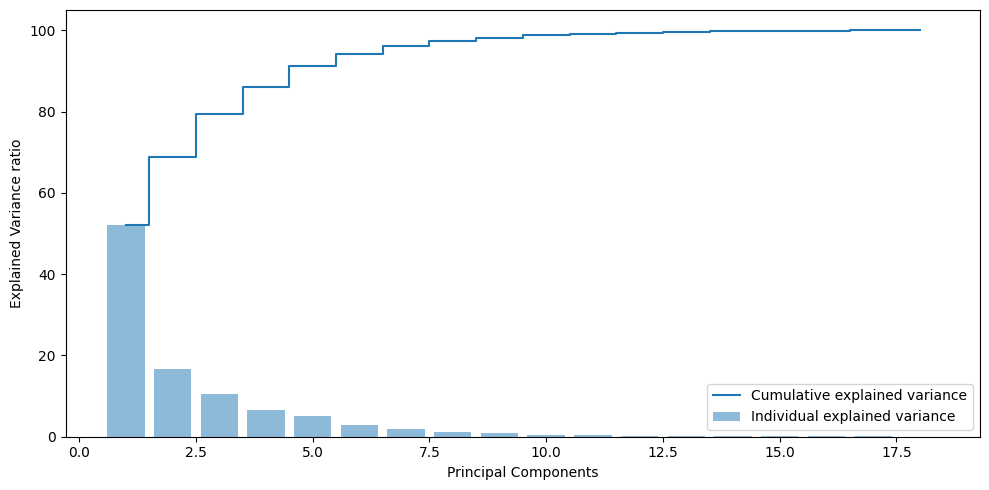

In [83]:
# plotting cumulative variance explained with number of components

plt.figure(figsize=(10,5))
plt.bar(range(1, e_vals.size +1), var_exp, alpha = 0.5, align = 'center', label='Individual explained variance')
plt.step(range(1,e_vals.size + 1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


 2.3 e - Draw a horizontal line on the above plot to highlight the threshold of 90%.

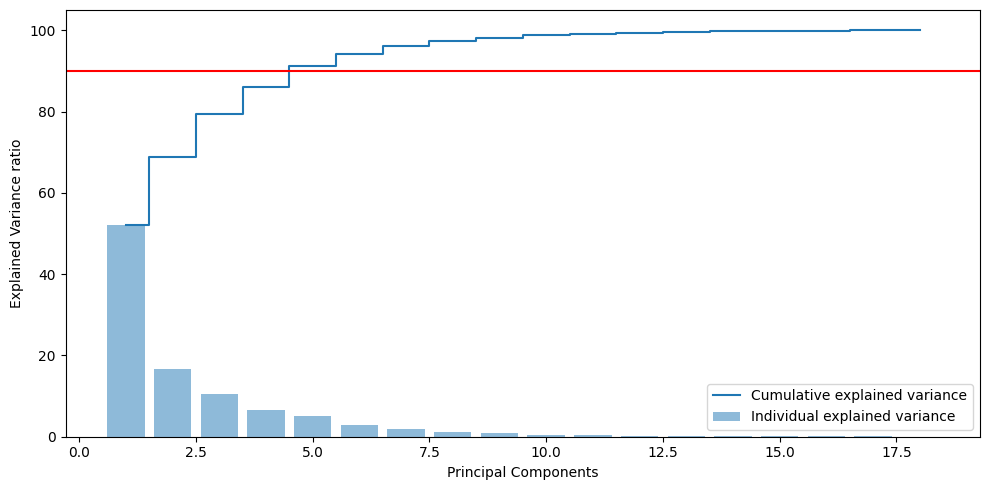

In [84]:
plt.figure(figsize=(10,5))
plt.bar(range(1, e_vals.size +1), var_exp, alpha = 0.5, align = 'center', label='Individual explained variance')
plt.step(range(1,e_vals.size + 1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained Variance ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=90, color='r', linestyle='-')
plt.show()

 2.3 f - Apply PCA on the data. This time Select Minimum Components with 90% or above variance explained.

In [85]:
# we select 5 components which are all above 90% variance
pca5 = PCA(n_components=5)
pca5.fit(X_std)

PCA(n_components=5)

In [86]:
print(pca5.explained_variance_)

[9.40460261 3.01492206 1.90352502 1.17993747 0.91726063]


In [87]:
print(pca5.explained_variance_ratio_)

[0.52186034 0.16729768 0.10562639 0.0654746  0.05089869]


2.3 g - Train SVM model on components selected from above step.

In [88]:
Xpca5=pca5.transform(X_std)

X_train_pca, X_test_pca, y_train, y_test =train_test_split(Xpca5, Y, test_size=0.20, random_state=100)
svm_model.fit(X_train_pca, y_train)
y_pred=svm_model.predict(X_test_pca)

3.H. Print Classification metrics for train data of above model and share insights.

In [89]:
print("SVM model score of train data after PCA: ", svm_model.score(X_train_pca, y_train))
print("SVM model score of test data after PCA: ", svm_model.score(X_test_pca, y_test))
print("Accuracy score of test data after PCA: ", metrics.accuracy_score(y_test, y_pred))


SVM model score of train data after PCA:  0.8165680473372781
SVM model score of test data after PCA:  0.788235294117647
Accuracy score of test data after PCA:  0.788235294117647


4. Performance Improvement:

4.A. Train another SVM on the components out of PCA. Tune the parameters to improve performance.

In [90]:
# Considering 10 principle components to view the performance
pca10 = PCA(n_components=10)
pca10.fit(X_std)

PCA(n_components=10)

In [108]:
Xpca10=pca10.transform(X_std)

X_train_pca, X_test_pca, y_train, y_test =train_test_split(Xpca10, Y, test_size=0.20, random_state=100)
svm_model.fit(X_train_pca, y_train)
y_pred=svm_model.predict(X_test_pca)
y_train_predict = svm_model.predict(X_train_pca)

applying grid search cv to model

In [92]:
param_grid = {'C': [0.1, 1, 10, 100],
'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
'kernel': ['rbf']}


In [93]:
gs=GridSearchCV(svm_model, param_grid,refit=True, verbose=3)

In [94]:
gs.fit(X_train_pca, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.511 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.519 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.519 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.519 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.816 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.859 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.837 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.815 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.844 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.515 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

4.B. Share best Parameters observed from above step

In [95]:
print(gs.best_params_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [96]:
print(gs.best_estimator_)

SVC(C=10, gamma=0.1)


In [97]:
gs.cv_results_['params']

[{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 1, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}]

In [98]:
gs.cv_results_['mean_test_score']

array([0.51627451, 0.83434641, 0.51627451, 0.51627451, 0.51627451,
       0.82393246, 0.96008715, 0.92163399, 0.52071895, 0.51627451,
       0.84759259, 0.9645098 , 0.94972767, 0.88167756, 0.52071895,
       0.84759259, 0.96153595, 0.95561002, 0.93344227, 0.8698366 ])

4.C. Print Classification metrics for train data of above model and share relative improvement in performance in all the models along with
insights

In [100]:
print("SVM model score of train data after PCA: ", gs.score(X_train_pca, y_train))
print("SVM model score of test data after PCA for 10 dimensions: ", gs.score(X_test_pca, y_test))
print("Accuracy score of test data after PCA for 10 dimensions: ", metrics.accuracy_score(y_test, y_pred))

SVM model score of train data after PCA:  0.9970414201183432
SVM model score of test data after PCA for 10 dimensions:  0.9470588235294117
Accuracy score of test data after PCA for 10 dimensions:  0.9294117647058824


In [115]:
print("Classification report for train data")
print(metrics.classification_report(y_train,y_train_predict, labels=[1,0]))


Classification report for train data
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:604: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will pe

We can see that as we apply grid search cv and select 10 PCA's the score of the model increases. The train data has score of 99% as compared to 81% earlier, which is a big increase and makes model reach optimum value.
The test data score also increases from 78% to 94%. This also signifies the importance of grid search cv which chooses correct parameters required for modelling.

5. Data Understanding & Cleaning:

5.A. Explain pre-requisite/assumptions of PCA

1.   Variables are numeric and independent
2.   Independent variables are highly co-related to each other
3.   Variables are scaled or standardized
4.   Number of outliers should be less

5.B. Explain advantages and limitations of PCA

Advantages


1. Helps to reduce Dimension thus reducing dependency between independent dimensions
2. Increase Signal to Noise ratio i.e. increase signal content and reduce noise content in the data by transforming existing dimensions
3. Variable reduction as we get PC variables
4. It standardizes/ centers the data
5. Removes dependency present in the data by eliminating the features that contain the same information
6. Increases the speed of execution as it removes the variables that do not help in decision making. With fewer featurestraining time of algorithm decreses


Limitations

1.   The model will work mostly when data has strong linear correlation between independent variables
2. After applying principal component analysis to the dataset, original features will be transformed into Principal Components. Original features are more legible and interpretable than Principal Components causing difficulty in comprehending






In [118]:
jupyter nbconvert --to html Project4_Unsupervised_Learning.ipynb

SyntaxError: ignored